# Level 1 Requirement Flowdown Overview

## L1-3 Global Fluxes (Global Mode)

> Carbon-I shall obtain column averaged mixing ratios with a standard error of ≤12 ppb CH4, ≤2.5 ppm CO2, and ≤10 ppb for CO once averaged to a 12 km × 12 km grid resolution for over 50% of such grid each month¹.  

¹: Averaged over 12 months. 

---

## Overview
This notebook demonstrates how we propagate top-level science requirements (L1 requirements) down to specific instrument specifications (e.g., readout noise, total system efficiency, etc.). In short, we start from a desired measurement precision on the **proxy gas** (like N₂O or CH₄) and systematically convert that into constraints on photon-collection efficiency, detector quantum efficiency, readout noise, and other instrument parameters. The result is an iterative process to ensure the instrument’s design meets the required performance with sufficient margin.

## Key Steps

1. **Defining the Required Proxy Precision**  
   - We begin by specifying the L1 requirement for single-sounding precision on the proxy gas (for instance, CH₄ or N₂O).  
   - In code, this is represented by variables like `sigma_rel_SingleSounding_req` (the fractional precision we need for each measurement) and the corresponding thresholds on background VMR (volume mixing ratio).

2. **Mapping Precision to Total Efficiency**  
   - We relate the allowable noise-equivalent error in our proxy measurement to a required total system efficiency.  
   - The total system efficiency includes optical throughput (bench efficiency), detector quantum efficiency (FPA QE), and any other relevant throughput factors. In the notebook, this is where arrays such as `TotalEfficiencies` and curves labeled “Readout Noise = 100 e⁻” or “Readout Noise = 120 e⁻” come from.  
   - By sweeping total efficiency and calculating the resulting proxy error, we find the minimal efficiency needed to meet the L1 precision requirement.

3. **Margin Assessment**  
   - Once we know the required total system efficiency (the dashed or dotted lines in the “From required proxy precision to total system efficiency” chart), we compare it to our current best-estimate design (CBE) value.  
   - The code visualizes this “margin” as the difference between (1) the efficiency needed to meet the requirement and (2) the predicted or measured efficiency from the current design. A healthy margin indicates the design should comfortably meet the requirement, while a smaller margin flags the need for further design optimization or risk mitigation.

4. **Noise Model Computations**  
   - We use a detailed noise model (`InstrumentOperator.createGratingNoiseModel`) to see how readout noise, dark current, integration time, optical throughput, and detector pitch/f-number all affect the ultimate measurement signal-to-noise ratio (SNR).  
   - For example, `ins_req_forSNR` and `ins_cbe_forSNR` reflect two scenarios:
     1. **`ins_req_forSNR`**: The “requirement” scenario (e.g., readout noise = 120 e⁻, required total efficiency).  
     2. **`ins_cbe_forSNR`**: The “current best estimate” scenario (e.g., readout noise = 100 e⁻, CBE total efficiency).  
   - We then convert the resulting signal and noise estimates to a **Noise Equivalent Spectral Radiance (NESR)** to compare it against the required radiance precision.

5. **Aggregating Multiple Soundings**  
   - The notebook further analyzes how multiple co-added soundings or aggregated observations reduce the overall error. Variables such as `N_eff_global_cbe` demonstrate how many soundings are effectively combined to meet mission-level goals.  
   - This aggregation further improves the measurement precision relative to a single sounding, which is crucial for meeting the science requirements when overheads, revisit times, or coverage constraints are considered.

6. **Checking CBE Performance Against L1**  
   - Finally, the notebook checks if the CBE instrument performance (including total efficiency, readout noise, and other specs) yields a proxy-gas retrieval error below the L1 threshold. For instance, the line:
     ```julia
     sigma_rel_cbe_agg = proxy_error / sqrt(N_eff_global_cbe)
     ```
     verifies that when we account for both the single-sounding error (`proxy_error`) and the number of effective soundings, the aggregated precision meets or surpasses the top-level requirement.

## Conclusion
This flowdown captures how the **Carbon-I** instrument’s core parameters—efficiency, readout noise, integration time, and so on—tie directly back to the mission’s main science requirement: measuring the proxy-gas concentration with a certain precision. By carefully tracing through these links, we confirm that the instrument design, as captured by the current best estimates (CBE), is aligned with achieving the Level-1 science targets.

Let's codify these numbers

In [1]:
using Pkg 
# Activate the environment for the project
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM, Printf
using CairoMakie, DelimitedFiles, Statistics, Interpolations, NCDatasets, InstrumentOperator, LinearAlgebra
using Unitful, UnitfulEquivalences
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));
include(joinpath(dirname(pathof(CarbonI)), "readSun.jl"))
include(joinpath(dirname(pathof(CarbonI)), "Requirements", "common.jl"))
using LaTeXStrings
set_theme!(theme_ggplot2())
# Load darkest albedo:
darkest_albedo = readdlm("../../data/dark_veg_emit_emit20241130t131027.csv",',', skipstart=1);

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59


In [2]:
# Define numbers from L1 Requirements

# Global Mode (L1-4)
global_mode_ch4_error = 14.0            # in ppb
global_mode_co2_error = 3.0             # in ppm
global_mode_co_error  = 10.0            # in ppb

global_mode_grid_resolution = [12e3, 12e3]  # in m
global_mode_coverage = 50.0             # in percentage
global_mode_gsd_req  = [400.0, 400.0]   # in m
global_mode_gsd_cbe  = [303.0, 345.0]   # in m

# Reference Background VMRs
background_vmr_ch4 = 1900.0  # in ppb
background_vmr_co2 = 420.0   # in ppm
background_vmr_n2o = 330.0   # in ppb

330.0

In [3]:
# Read cloud median statistics in 10S-10N from Yinon
cs = readdlm("../../data/CloudStatsCentralAmazonia.dat");
cf_interp = LinearInterpolation(cs[:,1], cs[:,2], extrapolation_bc=Line());
gsds = 30:10:1000;

┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packages/Makie/RgxaV/src/conversions.jl:1445
┌ Warning: Unsupported marker: circ, using ● instead
└ @ Makie /home/cfranken/.julia/packa

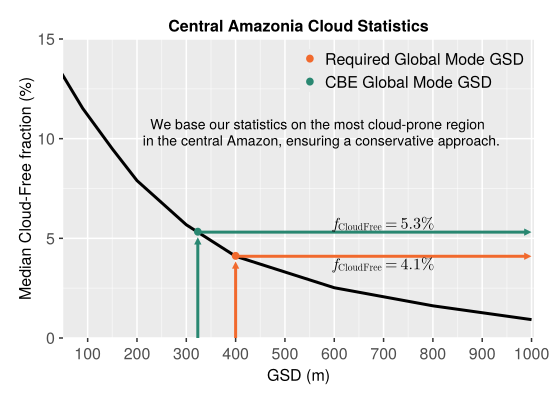

In [4]:

req_pix = sqrt(prod(global_mode_gsd_req))
cbe_pix = sqrt(prod(global_mode_gsd_cbe))
req_fcl = 100cf_interp(req_pix)
cbe_fcl = 100cf_interp(cbe_pix)

f = Figure(resolution=(550,400), backgroundcolor=:transparent)
ax = Axis(f[1,1], xlabel="GSD (m)", ylabel="Median Cloud-Free fraction (%)", xticks = 0:100:1000, title="Central Amazonia Cloud Statistics")
lines!(ax, gsds, 100cf_interp.(gsds), color=:black, linewidth=3)

scatter!(ax, req_pix, req_fcl, markersize = 10, marker = :circ, color = CarbonI_colors[5], label="Required Global Mode GSD")
#text!(ax,"Required Global Mode GSD", position = (req_pix, req_fcl),
#            align = (:right, :top), color = :black, fontsize=14)

scatter!(ax, cbe_pix, cbe_fcl, markersize = 10, marker = :circ,color = CarbonI_colors[3], label="CBE Global Mode GSD")
#text!(ax,"CBE Global Mode GSD", position = (cbe_pix, cbe_fcl),
#                        align = (:left, :bottom), color = :black, fontsize=14)

arrows!(ax, [req_pix,],[0,],[0,],[req_fcl-0.5,],arrowsize = 10, linewidth=3, color = CarbonI_colors[5])
arrows!(ax, [req_pix,],[req_fcl,] ,[1000-req_pix-10,],[0,],arrowsize = 10, linewidth=3, color = CarbonI_colors[5])

arrows!(ax, [cbe_pix,],[0,],[0,],[cbe_fcl-0.5,],arrowsize = 10, linewidth=3, color = CarbonI_colors[3])
arrows!(ax, [cbe_pix,],[cbe_fcl,] ,[1000-cbe_pix-10,],[0,],arrowsize = 10, linewidth=3, color = CarbonI_colors[3])

rounded_val = @sprintf("%1.1f", req_fcl)
# Build the full string with proper escapes:
full_label_str = "\$f_{\\text{CloudFree}} = $rounded_val \\text{%}\$"
# Convert it to a LaTeXString.
full_label = latexstring(full_label_str)
text!(ax, full_label, position = (700, req_fcl), align = (:center, :top), color = :black)
rounded_val = @sprintf("%1.1f", cbe_fcl)
# Build the full string with proper escapes:
full_label_str = "\$f_{\\text{CloudFree}} = $rounded_val \\text{%}\$"
# Convert it to a LaTeXString.
full_label = latexstring(full_label_str)
text!(ax, full_label, position = (700, cbe_fcl), align = (:center, :bottom), color = :black)

text!(ax, "We base our statistics on the most cloud-prone region \n in the central Amazon, ensuring a conservative approach.", position = (570, 9.5), align = (:center, :bottom), color = :black, fontsize=14)

xlims!(ax, 50, 1005)
ylims!(ax, 0, 15)
axislegend(ax,position = :rt)
save("../../plots/final/Level1-4-CloudStats.pdf",f)
f
#@show full_label

Now we can compute the potential number of footprints in the global grid, i.e.
$$
N_{max} = \frac{GSD_x \times GSD_y}{Grid_x \times Grid_y}
$$:

In [5]:
# Maximum number of global ground pixels in the 12km box
# Req.
N_max_global_req = prod(global_mode_grid_resolution)/prod(global_mode_gsd_req);
# At CBE
N_max_global_cbe = prod(global_mode_grid_resolution)/prod(global_mode_gsd_cbe);

And apply the conservative cloud statistics in the central Amazon (neglecting that we can tolerate higher sub-pixel clouds)

In [6]:
# Number of cloud-free global ground pixels in the 12km box
# Req.
N_eff_global_req = N_max_global_req * cf_interp(sqrt(prod(global_mode_gsd_req)));
# At CBE
N_eff_global_cbe = N_max_global_cbe * cf_interp(sqrt(prod(global_mode_gsd_cbe)));

We can now derive the requirement for $\sigma_{s}^{rel}$, as:
$$
\sigma_s^{rel} < \underbrace{\sigma_{agg}^{rel}}_{Required} \times \sqrt{N_{eff}}  
$$

In [7]:
sigma_rel_agg_global_req      =  min(global_mode_ch4_error/background_vmr_ch4 ,  global_mode_co2_error/background_vmr_co2)  # This should effectively be the same relative error for CO2 and CH4
sigma_rel_SingleSounding_req  =  sigma_rel_agg_global_req * sqrt(N_eff_global_req)  
sigma_rel_SingleSounding_cbe  =  sigma_rel_agg_global_req * sqrt(N_eff_global_cbe)
sigma_co_SingleSounding_req   =  global_mode_co_error * sqrt(N_eff_global_req) 
@printf("Required relative error in σ_agg : %.3g\n", 100*sigma_rel_agg_global_req)
@printf("Required Single Measurement Precision for N₂O in percent for req. GSD : %.3g\n", 100*sigma_rel_SingleSounding_req)
@printf("Required Single Measurement Precision for N₂O in percent for CBE specs: %.3g\n", 100*sigma_rel_SingleSounding_cbe)
@printf("Required Single Measurement Precision for CO in ppb for REQ specs: %.3g\n", sigma_co_SingleSounding_req)

Required relative error in σ_agg : 0.714
Required Single Measurement Precision for N₂O in percent for req. GSD : 4.34
Required Single Measurement Precision for N₂O in percent for CBE specs: 6.11
Required Single Measurement Precision for CO in ppb for REQ specs: 60.7


In [8]:
@printf("Required Single Measurement Precision for CO in ppb for REQ specs: %.3g", sigma_co_SingleSounding_req)

Required Single Measurement Precision for CO in ppb for REQ specs: 60.7

Just to show that the CH4 or CO2 precisions hardly matter for the relative errors:
$$
\sigma_{\mathrm{rel}}(R)
\;=\;\sqrt{\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{CH_4,CO_2}}\bigr)
+\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{N_2O}}\bigr)\,},
$$

In [9]:
σ_n2o = 3.5 # Error in %
σ_ghg = 0.5 # Error in % (CO2 and CH4, even smaller than that)
σ_rel = sqrt(σ_n2o^2 + σ_ghg^2)
ampl = σ_rel / σ_n2o
@printf("Error Enhancement factor if also considering GHG noise: %.3g", ampl)

Error Enhancement factor if also considering GHG noise: 1.01

In [10]:
# Now we have to set up the fit:
Δwl = 0.01
wl = 2000:Δwl:2400
#@show wlSol
clima_alb = readdlm(CarbonI.albedo_file,',', skipstart=1)
#soil = CubicSplineInterpolation(450:2500,r[:,140], extrapolation_bc=Interpolations.Flat());
tropical_forest_albedo = CubicSplineInterpolation(300:2400,clima_alb[:,2]/1.16/1.3, extrapolation_bc=Interpolations.Flat());
darkest_albedo_spline = LinearInterpolation(darkest_albedo[:,1],darkest_albedo[:,2], extrapolation_bc=Interpolations.Flat());
sol  = CubicSplineInterpolation(range(wlSol[1],wlSol[end], length=length(wlSol)),solar_irr, extrapolation_bc=Interpolations.Flat());
solarIrr = sol.(wl);
refl     = tropical_forest_albedo.(wl);

Now we have to show what instrument specs we require to get to that precision. 
--> We could bypass SNR and just use our tropical reference scene (with spectrally varying albedo) and compute sigma as function of total system efficiency (i.e. optical throughput and Qe)

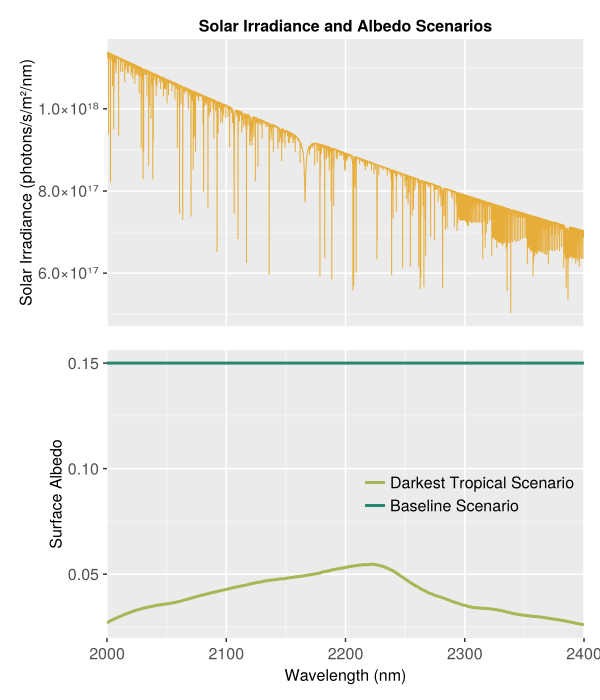

In [11]:
f = Figure(resolution=(600,700))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Solar Irradiance (photons/s/m²/nm)",  title="Solar Irradiance and Albedo Scenarios")
lines!(ax, wl,  solarIrr/1000 .* wl * 1e-9/ (6.626e-34 * 2.998e8), color=CarbonI_colors[1], linewidth=1)
ax2 = Axis(f[2,1], xlabel="Wavelength (nm)", ylabel="Surface Albedo")
lines!(ax2, wl, tropical_forest_albedo.(wl), color=CarbonI_colors[2], linewidth=3, label="Darkest Tropical Scenario")
lines!(ax2, wl, 0*tropical_forest_albedo.(wl).+0.15, color=CarbonI_colors[3], linewidth=3, label="Baseline Scenario")
#lines!(ax2, wl, darkest_albedo_spline.(wl), color=CarbonI_colors[3], linewidth=2)
xlims!(ax, 2000, 2400)
xlims!(ax2, 2000, 2400)
axislegend(ax2,position = :rc)
hidexdecorations!(ax, grid=false)
f

In [13]:
# Load stressing scenario (tropical forest)
scenario = CarbonI.stressing_scenario()

req_specs = CarbonI.build_instrument("Requirement") 
cbe_specs = CarbonI.build_instrument("CBE") 

# Create required Instrument model 
ins_req = InstrumentOperator.createGratingNoiseModel(req_specs.ET, req_specs.Pitch, 
		req_specs.FPA_quantum_efficiency, req_specs.bench_efficiency, 
		req_specs.Fnumber, 2*req_specs.SSI, 
		(req_specs.readout_noise), req_specs.dark_current); 

# Create required Instrument model
ins_cbe = InstrumentOperator.createGratingNoiseModel(cbe_specs.ET, cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

soil_req, x_req, solarIrr_req, σ_matrix_req, profile_req, h_req, Sₐ_req = setup_data(scenario, req_specs)
soil_cbe, x_cbe, solarIrr_cbe, σ_matrix_cbe, profile_cbe, h_cbe, Sₐ_cbe = setup_data(scenario, cbe_specs);
refl_req   = scenario.surface_albedo(req_specs.modelling_wl);
refl_cbe   = scenario.surface_albedo(cbe_specs.modelling_wl);

(ds["T"])[iLon, iLat, :, timeIndex] = Union{Missing, Float32}[205.17984, 205.28577, 204.3511, 205.65045, 211.39908, 219.25983, 225.50705, 229.22559, 234.98184, 241.08362, 247.89389, 254.52339, 259.31662, 260.55365, 261.2295, 260.91293, 257.9075, 254.52269, 250.68933, 247.50629, 245.75996, 242.73718, 241.07652, 237.61713, 235.17921, 236.70642, 230.41078, 229.94821, 222.20546, 218.0587, 214.88086, 212.21912, 209.32239, 206.50714, 197.59671, 192.69617, 194.36191, 199.31332, 201.06302, 203.26447, 209.37901, 217.33842, 226.74182, 236.74905, 245.94034, 253.06683, 256.719, 261.30786, 265.14124, 268.4499, 271.63074, 274.55365, 276.77612, 279.03894, 281.011, 282.8612, 284.70425, 286.3738, 287.6122, 288.7355, 289.78403, 290.64203, 290.84982, 291.21863, 292.01584, 293.05814, 294.24646, 295.5233, 296.82358, 298.12357, 299.40927, 300.6187]


In [14]:
@show scenario.surface_albedo(2130);

scenario.surface_albedo(2130) = 0.046440356364937735


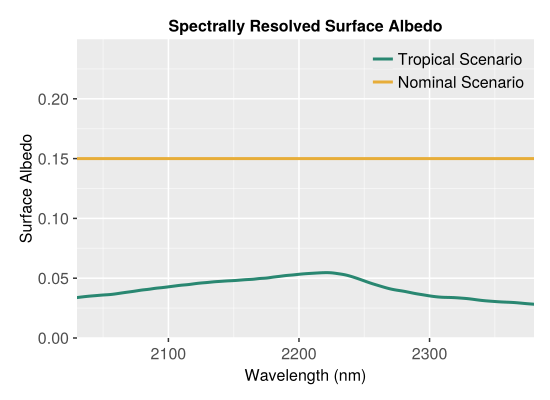

In [15]:
f = Figure(resolution=(550,400), backgroundcolor=:transparent)
#ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Solar Irradiance (photons/s/m²/nm)",  title="Solar Irradiance and Tropical Forest Albedo")
#lines!(ax, wl,  solarIrr/1000 .* wl * 1e-9/ (6.626e-34 * 2.998e8), color=CarbonI_colors[1], linewidth=1)
ax2 = Axis(f[1,1],title="Spectrally Resolved Surface Albedo", xlabel="Wavelength (nm)", ylabel="Surface Albedo")
lines!(ax2, wl, scenario.surface_albedo(wl), color=CarbonI_colors[3], linewidth=3, label="Tropical Scenario")
lines!(ax2, wl, 0*tropical_forest_albedo.(wl).+0.15, color=CarbonI_colors[1], linewidth=3, label="Nominal Scenario")
#lines!(ax2, wl, darkest_albedo_spline.(wl), color=CarbonI_colors[3], linewidth=2)
xlims!(ax, 2030, 2380)
xlims!(ax2, 2030, 2380)
ylims!(ax2, 0.0, 0.25)
axislegend(ax2,position = :rt)
hidexdecorations!(ax, grid=false)
save("../../plots/final/Level1-AlbedoScenarios.pdf",f)
f

In [16]:
error_req, F_req = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req, Sₐ_req, return_F=true) 
error_cbe, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe, Sₐ_cbe, return_F=true) 

(Dict{Any, Any}("ch4" => 22.729992460398844, "h2o" => 59890.17567878998, "co" => 110.66597039081358, "n2o" => 38.73437943121148, "hdo" => 554156.6452633719, "c2h6" => 53.415337213077834, "co2" => 4004.632301509355, "co213" => 34177.60839934944), [0.8584848779124291, 0.8586226880971571, 0.8141400785770572, 0.7050504342196676, 0.6781293881658732, 0.5994111317227759, 0.43722465401014404, 0.5324781791590005, 0.7265232399470012, 0.7469926812611734  …  0.3898217242970612, 0.3292428831655531, 0.21853973340190552, 0.18553457037848453, 0.16971454050076498, 0.16142353797591938, 0.1535754463790074, 0.07191411391152629, 0.048457522008025965, 0.12289298427411073])

In [17]:
@show error_cbe["co"]/sqrt(10)
@show error_cbe["co2"]/1e3/sqrt(10)
@show error_cbe["ch4"]/sqrt(10)

error_cbe["co"] / sqrt(10) = 34.99565259077251
(error_cbe["co2"] / 1000.0) / sqrt(10) = 1.2663759264251715
error_cbe["ch4"] / sqrt(10) = 7.187854737331495


7.187854737331495

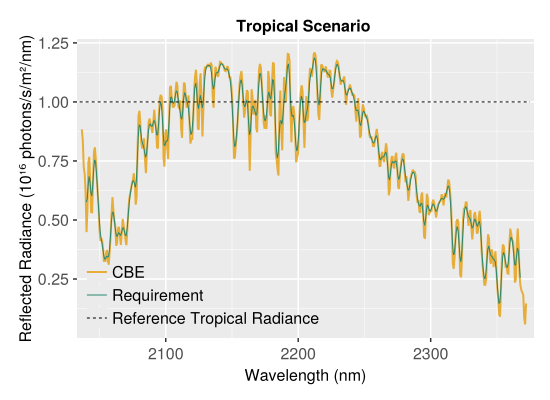

In [18]:
from_w_to_photons = 5.03e12
refRadiance = 1.0e16 # in photons/s/m²/nm

f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Reflected Radiance (10¹⁶ photons/s/m²/nm)",  title="Tropical Scenario ")
lines!(ax, cbe_specs.instrument_wl,F_cbe * from_w_to_photons .* cbe_specs.instrument_wl / 1e16, color=CarbonI_colors[1], linewidth=2, label="CBE")
lines!(ax, req_specs.instrument_wl,F_req * from_w_to_photons .* req_specs.instrument_wl / 1e16, color=CarbonI_colors[3], linewidth=1, label="Requirement")
lines!(ax, [2035,2375], [refRadiance/ 1e16,refRadiance/ 1e16], color=:black, linestyle=:dash, linewidth=1, label="Reference Tropical Radiance")
xlims!(ax, 2033, 2378)
axislegend(ax,position = :lb)
save("../../plots/final/Level1-3-TropicalScenario_radiance.pdf",f)
f

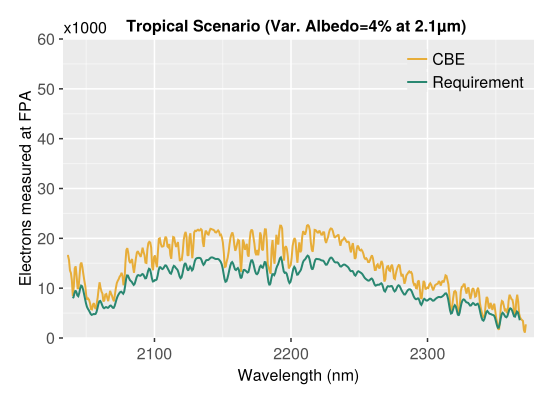

In [19]:
# Compute Electrons at FPA
e_cbe = InstrumentOperator.photons_at_fpa(ins_cbe, (cbe_specs.instrument_wl)u"nm", (F_cbe)u"mW/m^2/nm/sr");
e_req = InstrumentOperator.photons_at_fpa(ins_req, (req_specs.instrument_wl)u"nm", (F_req)u"mW/m^2/nm/sr");
from_w_to_photons = 5.03e12
refRadiance = 1.0e16 # in photons/s/m²/nm

f = Figure(resolution=(550,400))
ax = Axis(f[1,1], xlabel="Wavelength (nm)", ylabel="Electrons measured at FPA",  title="Tropical Scenario (Var. Albedo=4% at 2.1µm) ")
Label(f[1, 1, Top()], halign = :left, "x1000")
lines!(ax, cbe_specs.instrument_wl,e_cbe/1000, color=CarbonI_colors[1], linewidth=2, label="CBE")
lines!(ax, req_specs.instrument_wl,e_req/1000, color=CarbonI_colors[3], linewidth=2, label="Requirement")
#lines!(ax, [2035,2375], [refRadiance/ 1e16,refRadiance/ 1e16], color=:black, linestyle=:dash, linewidth=1, label="Reference Tropical Radiance")
xlims!(ax, 2033, 2378)
ylims!(ax, 0, 60)
axislegend(ax,position = :rt)
save("../../plots/final/Level1-3-TropicalScenario_FPA.pdf",f)
f

In [20]:
# Save Data for plotting
allData_fpa_cbe = [cbe_specs.instrument_wl e_cbe];
allData_fpa_req = [req_specs.instrument_wl e_req];
writedlm("../../data/L1s/Level1-3-BaselineScenario_FPA_CBE.csv", allData_fpa_cbe);
writedlm("../../data/L1s/Level1-3-BaselineScenario_FPA_Req.csv", allData_fpa_req);

In [ ]:
# Now vary total efficiency at two different readout noise levels:

TotalEfficiencies = 0.3:0.05:1.0
n2o_errors_100 = zeros(length(TotalEfficiencies))
n2o_errors_120 = zeros(length(TotalEfficiencies))
for (i,efficiency) in enumerate(TotalEfficiencies)
    # Create instrument Specs here:
    # (here we need to use 57ms integration time for req. as we count 400m pixels along track dimension)
    ins_req_100 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (100.0), req_specs.dark_current); 
    ins_req_120 = InstrumentOperator.createGratingNoiseModel(57.0u"ms", req_specs.Pitch, 1.0, efficiency, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current); 
    # Create an error for 100 and 120e- for the respective efficiency
    error_varied_100 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_100, Sₐ_req) 
    error_varied_120 = calc_rel_error(req_specs, x_req, solarIrr_req, refl_req, scenario.sza, σ_matrix_req, profile_req, h_req, ins_req_120, Sₐ_req) 
    # Store Data
    n2o_errors_100[i] = error_varied_100["n2o"]/background_vmr_n2o/sqrt(req_specs.coadd_rate)
    n2o_errors_120[i] = error_varied_120["n2o"]/background_vmr_n2o/sqrt(req_specs.coadd_rate) 
end

In [ ]:
# Create an interpolation function to get the required optical efficiency for a given readout noise and proxy error for N2O
# Annoying as it requires ascending order in the x-axis
efficiency_100 = LinearInterpolation(reverse(100(n2o_errors_100)), reverse(TotalEfficiencies), extrapolation_bc=Line());
efficiency_120 = LinearInterpolation(reverse(100(n2o_errors_120)), reverse(TotalEfficiencies), extrapolation_bc=Line());

In [ ]:
f = Figure(resolution=(550,400), backgroundcolor=:transparent)
ax = Axis(f[1,1], xlabel="Total System Efficiency", ylabel="Relative Proxy Precision (%)",  title="From required precision to total system efficiency (Global Mode)")
lines!(ax, TotalEfficiencies, n2o_errors_100*100, color=CarbonI_colors[1], linewidth=3, label="Readout Noise = 100e⁻")
lines!(ax, TotalEfficiencies, n2o_errors_120*100, color=CarbonI_colors[3], linewidth=3, label="Readout Noise = 120e⁻")

req_error        = 100*sigma_rel_SingleSounding_req /ampl
req_error_cbeGSD = 100*sigma_rel_SingleSounding_cbe /ampl
req_eff          = efficiency_100(req_error)
req_eff_120      = efficiency_120(req_error)

eff_cbe = cbe_specs.bench_efficiency * cbe_specs.FPA_quantum_efficiency

arrows!(ax, [0.0,],[req_error,],[req_eff,],[0,],arrowsize = 15, linewidth=3,color = CarbonI_colors[5])
arrows!(ax, [0.0,],[req_error,],[req_eff_120-0.01,],[0,],arrowsize = 15, linewidth=3, color = CarbonI_colors[5])
arrows!(ax, [req_eff_120,],[req_error,],[eff_cbe-req_eff_120-0.005,],[0,],arrowsize = 15, linewidth=3, color = :black)
text!(ax, "Margin", position = (0.5, req_error),  align = (:center, :bottom), color = :black)
#arrows!(ax, [req_eff,],[req_error,],[0,],[-req_error+2.05,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
#text!(ax, "Req: > $(round(Int, 100req_eff))%", position = (req_eff, 2.5),
#    align = (:center, :bottom), color = :black, rotation=π/2)

arrows!(ax, [req_eff_120,],[req_error,],[0,],[-req_error+2.1,],arrowsize = 15, linewidth=3, color = CarbonI_colors[5])

scatter!(ax, [req_eff_120], [req_error], color=:red, markersize=15, label="Driving Req.")

text!(ax, "Req: > $(round(Int, 100req_eff_120))%", position = (req_eff_120, 2.55),
    align = (:center, :bottom), color = :black, rotation=π/2)
lines!(ax, [eff_cbe,eff_cbe], [2,6], color=:black, linestyle=:dash, linewidth=2, label="CBE Total Efficiency")
#arrows!(ax2, [req_percent_ch4,],[req_flux_ch4,],[-req_percent_ch4+1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
#text!(ax2, "Req. >90%", position = (req_percent_ch4, 25),
#      align = (:center, :bottom), color = :black, rotation=π/2)

axislegend(ax,position = :rt)
xlims!(ax,0.3,0.8)
ylims!(ax,2,5)
save("../../plots/final/Level1-3-EfficiencyDerivation.pdf",f)
f

In [ ]:
# Save lines to merge later with other requirements:
AllData = [TotalEfficiencies n2o_errors_100*100 n2o_errors_120*100 ];

writedlm("../../data/L1s/L1-3_lines.dat", AllData)
writedlm("../../data/L1s/L1-3_req_error.dat", req_error)

In [ ]:
ins_req_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", req_specs.Pitch, 1.0, req_eff_120, req_specs.Fnumber, 2*req_specs.SSI, (120.0), req_specs.dark_current);
ins_cbe_forSNR = InstrumentOperator.createGratingNoiseModel(44.0u"ms", cbe_specs.Pitch, 1.0, eff_cbe, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current);
# Use reference Wavelength here (just for conversion)
ref_wl = 2250;


refRadiance_mw = refRadiance / from_w_to_photons / ref_wl
nesr_req_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_req_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");
nesr_cbe_forSNR = InstrumentOperator.noise_equivalent_radiance(ins_cbe_forSNR, (ref_wl)u"nm", (refRadiance_mw)u"mW/m^2/nm/sr");

@printf("Required SNR @1e16 photons/m2/sr/nm/s: %.4g\n",  refRadiance_mw/(nesr_req_forSNR[1]./1u"mW/m^2/nm/sr"))
@printf("CBE      SNR @1e16 photons/m2/sr/nm/s: %.4g ",  refRadiance_mw/(nesr_cbe_forSNR[1]./1u"mW/m^2/nm/sr"))

In [ ]:
#ins_cbe_forProxy = InstrumentOperator.createGratingNoiseModel(57.0u"ms", cbe_specs.Pitch, 1.0, eff_cbe, cbe_specs.Fnumber, 2*cbe_specs.SSI, (100.0), cbe_specs.dark_current);
ins_cbe_forProxy = InstrumentOperator.createGratingNoiseModel(57.0u"ms", cbe_specs.Pitch, 
		cbe_specs.FPA_quantum_efficiency, cbe_specs.bench_efficiency, 
		cbe_specs.Fnumber, 2*cbe_specs.SSI, 
		(cbe_specs.readout_noise), cbe_specs.dark_current); 

error_cbe_forProxy, F_cbe = calc_rel_error(cbe_specs, x_cbe, solarIrr_cbe, refl_cbe, scenario.sza, σ_matrix_cbe, profile_cbe, h_cbe, ins_cbe_forProxy, Sₐ_cbe, return_F=true) 
proxy_error_400m = error_cbe_forProxy["n2o"]/background_vmr_n2o/sqrt(req_specs.coadd_rate)
@printf("CBE Proxy Error at 400m: %.3g  \n", 100proxy_error_400m)

## Compute CBE back to L1 requirements

In [ ]:
# Computing CBE for L1-5:
proxy_error = error_cbe["n2o"]/background_vmr_n2o/sqrt(req_specs.coadd_rate)
sigma_rel_cbe_agg = proxy_error / sqrt(N_eff_global_cbe)

@printf("CBE Proxy Error: %.3g  \n", proxy_error)
@printf("CBE Standard Error for CH₄ : %.2g ppb\n", sigma_rel_cbe_agg*background_vmr_ch4) 
@printf("CBE Standard Error for CO₂ : %.2g ppm\n", sigma_rel_cbe_agg*background_vmr_co2)
@printf("CBE Standard Error for CO  : %.2g ppb\n", error_cbe["co"]/ sqrt(N_eff_global_cbe) / sqrt(req_specs.coadd_rate))

# From before:
@printf("Required relative error in σ_agg : %.3g percent\n", 100*sigma_rel_agg_global_req)
@printf("Required Single Measurement Precision for N₂O in percent for req. GSD : %.3g\n", 100*sigma_rel_SingleSounding_req)
@printf("Required Single Measurement Precision for N₂O in percent for CBE specs: %.3g\n", 100*sigma_rel_SingleSounding_cbe)
@printf("Required Single Measurement Precision for CO in ppb for REQ specs: %.3g\n", sigma_co_SingleSounding_req)

# Total System Efficiency
@printf("Required Total System Efficiency: %.3g\n", req_eff_120)

# Pixels:
# Pixels:
@printf("Number of cloud-free Pixel in Required GSD: %.3g\n", N_eff_req_global)
@printf("Number of cloud-free Pixel in CBE GSD: %.3g\n", N_eff_cbe_global)

### The End